# First Prototype for generating a more sophisticated web app

import libs and load data

In [1]:
# local utilities
import os
import sys
module_path = os.path.abspath(os.path.join('../../'))
if module_path not in sys.path:
    sys.path.append(module_path)

from utilities.BTTools import filter_for
from utilities.BTTools import groupSpeechesByDiscussionTitle

# other stuff needed
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.datasets import make_multilabel_classification
from sklearn.decomposition import NMF
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import normalize

import matplotlib.pyplot as plt
import tqdm

import json

with open('../../data/speeches_20.jsonl', 'r', encoding='utf8') as fp:
    data = list(fp)
speeches_original = []
for line in data:
    speeches_original.append(json.loads(line))
    
speeches = speeches_original.copy()    

# Level I

## 1. Topic Model at the level of TOPs


### 1.1 Create Corpus

#### restructure data per TOP

In [2]:
groupedby_discussion = groupSpeechesByDiscussionTitle(speeches)
len(groupedby_discussion)

337

In [29]:
#list(groupedby_discussion.items())[1]

#### build corpus for scikit learn methods

In [3]:
corpus = []
for top in groupedby_discussion.values():
    #print(grouped[top])
    aggregate= []
    for ele in top:
        aggregate.append(ele['text'])
    corpus.append(' '.join(aggregate))

len(corpus)


337

#### optional: preprocessing with spacy

In [5]:

import spacy
nlp = spacy.load('de') #load spacy model


In [6]:

def corpus_by_POS(corpus,consider):
    corpus_by = []  
    for row in tqdm.tqdm(corpus):
        doc = nlp(row)
        new_row = []
        for token in doc:
            if token.pos_ in consider:
                new_row.append(token.lemma_)
        corpus_by.append(' '.join(new_row))
    return corpus_by 


In [7]:
consider = ['NOUN']
        
corpus_nouns = corpus_by_POS(corpus,consider)        
len(corpus_nouns)

100%|██████████| 208/208 [03:11<00:00,  1.09it/s]


208

In [7]:
corpus = corpus_nouns
corpus[0]

'Kraft Wohle Volk Nutzen Schaden Grundgesetz Gesetz Bund Pflicht Gerechtigkeit'

### 1.2 Topic Model

#### vectorize data

In [43]:
vectorizer_tfidf = TfidfVectorizer(max_df=0.8, min_df=0.01,lowercase = False)
tf_idf_matrix  = vectorizer_tfidf.fit_transform(corpus)
feature_names = vectorizer_tfidf.get_feature_names()
vectorizer_tf = TfidfVectorizer(vocabulary=feature_names,use_idf=False, norm="l1",lowercase = False)
#vectorizer_counts = CountVectorizer(vocabulary=feature_names)
tf_matrix = vectorizer_tf.fit_transform(corpus)

tf_idf_matrix

<337x22591 sparse matrix of type '<class 'numpy.float64'>'
	with 516113 stored elements in Compressed Sparse Row format>

#### compute topic model

#### <font color='red'>From here on I now use a dict structure!</font>

In [44]:
# Use NMF to look for 15 topics
n_topics = 10
model = NMF(n_components=n_topics)
model.fit(tf_idf_matrix)
#model.fit(tf_matrix)

# Print the top 10 words
n_words = 100
#n_words_features = 100

topic_names = []
topic_words = []
# new: store in dict
topics = []  
for topic_idx, topic in enumerate(model.components_):
    t_words = [feature_names[i] for i in topic.argsort()[-n_words:]][::-1]
    t_words_string = ' '.join(t_words[:10])
    topic_names.append(f"topic_{'_'.join(t_words[:3])}") 
    #topic_list_ext.append(top_features)
    
#    top_n = [feature_names[i]
#             for i in topic.argsort()
#             [-n_words_features:]][::-1]
    topic_words.append(t_words)
    topic_dict = { 'name' : f"topic_{'_'.join(t_words[:3])}",
                   'words' : t_words,
                   'tops' : []  
                    }
    topics.append(topic_dict)
    print(f"Topic {topic_idx}: {t_words_string}")

# for empty data (speeches without text)
topic_dict = { 'name' : 'rest',
               'words' : [],
               'tops' : []  
                }
topics.append(topic_dict)    
    
topic2word = model.components_   
#topics

Topic 0: Euro Haushalt Milliarden Millionen Ministerin Mittel Geld Einzelplan Schuldenbremse Investitionen
Topic 1: Ukraine Russland Europa Krieg NATO Putin Bundeskanzler EU Waffen Europäischen
Topic 2: Impfpflicht Impfung Pandemie Pflege impfen Omikron Lauterbach Impfungen Impfen Maßnahmen
Topic 3: Energien Gas erneuerbaren Ausbau Strom LNG Energiewende Winter Energieversorgung Energie
Topic 4: Mali Mandat Soldaten Mission Soldatinnen MINUSMA Einsatz Region Niger Libyen
Topic 5: Frauen Kinder Kommunen Antrag Kollegin Bildung Bund 219a Gesetzentwurf Ministerin
Topic 6: Inflation Euro Einkommen Entlastung Progression entlasten Maßnahmen Preise Rentner Milliarden
Topic 7: Landwirtschaft Landwirte Ernährung Hunger Bauern Lebensmittel Millionen Flächen Weizen Antrag
Topic 8: ÖPNV Ticket Mobilität Euro Bahn Schiene Auto Bus ländlichen Verkehr
Topic 9: Bundeswehr Soldaten Sondervermögen Soldatinnen Beschaffung Milliarden Ausrüstung Zeitenwende Afghanistan Truppe


In [26]:
len(topics)

11

#### Word Clouds for Topic

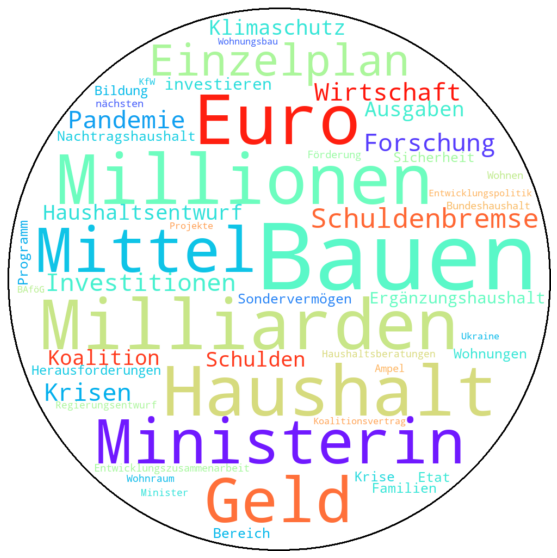

In [45]:
import numpy as np
from PIL import Image
from wordcloud import WordCloud

mask = np.array(Image.open("circle.png"))

# parameters:

wordcloud = WordCloud(background_color='white', max_words=50, mask=mask, contour_color='#000000', contour_width=3, colormap='rainbow').generate(" ".join(topic_words[0]))

# create image as circle

fig = plt.figure(figsize=(10,10))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")

# presentate:

plt.show()


# generate PNG for all topics
for tx,topic in enumerate(topics):
    if topic['name'] == 'rest':
        pass
    else:
        wordcloud = WordCloud(background_color='white', max_words=50, mask=mask, contour_color='#000000', contour_width=3, colormap='rainbow').generate(" ".join(topic['words']))
        wordcloud.to_file(f"wordclouds/wordcloud_{tx}.png")


#### document topic probabilities

In [46]:
print(tf_matrix.shape)
print(topic2word.shape)
doc2topic = (tf_matrix * topic2word.T)
print(doc2topic.shape)

(337, 22591)
(10, 22591)
(337, 10)


In [ ]:
topic2word.T[0]

#### find max contributions for words and docs

In [47]:
feature_topic_num = []
feature_topic_name = []
for wx,word in enumerate(feature_names):
    if topic2word.T[wx].max() > 0:
        topic_num = topic2word.T[wx].argmax()
        topic_name = topic_names[topic_num]
    else:
        topic_num = n_topics
        topic_name = 'not defined'
    
    feature_topic_num.append(topic_num)
    feature_topic_name.append(topic_name)
#feature_topic_num

top_topic_num = []
top_topic_name = []
for tx,top in enumerate(groupedby_discussion):
    if doc2topic[tx].max() > 0:
        topic_num = doc2topic[tx].argmax()
        topic_name = topic_names[topic_num]
    else:
        topic_num = n_topics
        topic_name = 'not defined'
    
    top_topic_num.append(topic_num)
    top_topic_name.append(topic_name)
        
    # update topic dict   
    topics[topic_num]['tops'].append(top)

    
#feature_topic_name

In [49]:
topics[9]

{'name': 'topic_Bundeswehr_Soldaten_Sondervermögen',
 'words': ['Bundeswehr',
  'Soldaten',
  'Sondervermögen',
  'Soldatinnen',
  'Beschaffung',
  'Milliarden',
  'Ausrüstung',
  'Zeitenwende',
  'Afghanistan',
  'Truppe',
  '100',
  'NATO',
  'Euro',
  'Ukraine',
  'Beschaffungswesen',
  'Ausstattung',
  'Sicherheit',
  'Verantwortung',
  'Streitkräfte',
  'Verteidigung',
  'Untersuchungsausschuss',
  'Verteidigungsfähigkeit',
  'Munition',
  'Verteidigungshaushalt',
  'Bündnisverteidigung',
  'Geld',
  'Waffen',
  'Material',
  'Ministerin',
  'Freiheit',
  'Gerät',
  'Landes',
  'Europa',
  'Verteidigungsministerin',
  'verteidigen',
  'Wehrbeauftragte',
  'Grundgesetzänderung',
  'Einsatz',
  'Krieg',
  'schulden',
  'erfüllen',
  'Bundeswehrbeschaffungsbeschleunigungsgesetz',
  'Parlamentsarmee',
  'Bundeskanzler',
  'Drohnen',
  'Dienst',
  'Enquete',
  'Grundgesetz',
  'Frieden',
  'Landesverteidigung',
  'Lambrecht',
  'Bericht',
  'Sondervermögens',
  'Beschaffungen',
  'Eins

In [32]:
def filter_for(what, search_terms, speeches):
    filtered_speeches = []
    if what == 'text':
        search_terms_low = []
        for st in search_terms:
            search_terms_low.append(st.lower())
        for speech in speeches:
            match = [st in speech[what].lower() for st in search_terms_low]
            #if all(st == True for st in match):
            if any(st in speech[what] for st in search_terms):
                #print(match)
            #if ( search_terms in speech[what] ):
                filtered_speeches.append(speech)
    else:
        for speech in speeches:
            if ( speech[what] in set(search_terms) ):
                filtered_speeches.append(speech)
        
    filtered_speeches.sort(key = lambda x:x['date'])   
    return filtered_speeches

In [50]:
subset_reaktionen = filter_for('discussion_title', topics[7]['tops'], speeches)
len(subset_reaktionen)

80

183

## 1.3 Generate Topic Network (I take now Julians Version)

In [17]:
from sklearn.metrics.pairwise import cosine_similarity

def get_topic2_topic(tm):
    normalized_matrix = normalize(tm.components_, axis=1, norm='l1')
    print(f'normalized_matrix: {normalized_matrix.shape}')

    topic_to_topic = cosine_similarity(normalized_matrix)
    print(f'topic2topic: {topic_to_topic.shape}')

    return topic_to_topic

def create_topic2topic_graph(t2t, extended_topic_list):
    nodes = []
    count = 1

    for i, topic in enumerate(topics):
        if topic['name'] == 'rest':
            pass
        else:
            nodes.append({
                'id': count,
                'name': topic['name'],
                'nTops': len(topic['tops'])+1
            })
            count += 1

    graph = {
        'directed': False,
        'graph': 'semant_graph',
        'links': [],
        'nodes': nodes
    }

    for i, node_i in enumerate(graph['nodes']):
        for j, node_j in enumerate(graph['nodes']):
            if i < j:
                source = node_i['id']
                target = node_j['id']
                weight = t2t[i, j]
                if weight > 0.15:
                    link = {
                        'source': source,
                        'target': target,
                        'weight': weight
                    }
                    graph['links'].append(link)

    return graph

def get_graph_template(graph, properties):
    node_label = properties['nodelabel']
    node_coloring = properties['nodecoloring']
    node_size = properties['nodesize']

    lv = '//' if properties['edgevisibility'] else ''
    parts = '//' if not properties['particles'] else ''
    dm = '//' if not properties['darkmode'] else ''

    d3graph = {
        'nodes': graph['nodes'],
        'links': graph['links']
    }

    htmlcode = f"""<head>
        <style>
            body {{margin: 0;}}
            h3 {{text-align: center;}}
            .center {{
              display: block;
              margin-left: auto;
              margin-right: auto;
            }}
        </style>
        <script src="https://unpkg.com/force-graph"></script>
        <meta charset="UTF-8">
    </head>
    <body>
    <img src="Logo.png" height="150" width="300" class="center">
    <h3>DebSearch ist eine statistische Website, welche die aktuelle Legislaturperiode</h3>
    <h3>in verschiedenen Kategorieren auswertet und visualisiert.</h3>
    <div id="graph"></div>
    <script>
        var data = {d3graph};
        const elem = document.getElementById('graph');
        const Graph = ForceGraph()(elem)
            .graphData(data)
            .nodeLabel('{node_label}')
            .nodeRelSize(1)
            .nodeVal('{node_size}')
            .nodeAutoColorBy('{node_coloring}')
            {dm}.backgroundColor('#000000')
            {dm}.linkColor(() => 'rgba(255,255,255,0.2)')
            {lv}.linkVisibility('false')
            {parts}.linkDirectionalParticles(2)
            {parts}.linkDirectionalParticleWidth(1.4)
            //.onNodeClick (node => {{window.open('./TOPnets/TOPnet4topic0.html', '_blank')}})
            .onNodeClick (node => {{window.open(`./TOPnets/TOPnet4topic${{node.id-1}}.html`, '_blank')}})
            //.onNodeHover(node => elem.style.cursor = node ? 'pointer' : null)
            .onNodeRightClick(node => {{
                // Center/zoom on node
                Graph.centerAt(node.x, node.y, 1000);
                Graph.zoom(4, 2000);
            }});
    </script>
    </body>
    """

    return { 'graph': htmlcode }

In [18]:
topic2topic = get_topic2_topic(model)

t2t_graph = create_topic2topic_graph(topic2topic, topic_list)

print(f"got a graph with {len(t2t_graph['nodes'])} nodes.")
print('the first node:')
print(t2t_graph['nodes'][0])


properties = {
    'nodecoloring':'name',
    'nodelabel': 'name',
    'nodesize': 'nTops',
    "darkmode": False,
    "edgevisibility": True,
    "particles": False
}

html_graph = get_graph_template(t2t_graph, properties)

with open(f'./topic_network.html', 'w') as f:
    f.write(html_graph['graph'])

normalized_matrix: (10, 22591)
topic2topic: (10, 10)


NameError: name 'topic_list' is not defined

In [27]:
list(groupedby_discussion.items())[1]

('Tagesordnungspunkt 2 2022-04-27',
 [{'text': 'Frau Präsidentin! Sehr geehrte Kolleginnen und Kollegen! Eine Regierungsbefragung zu Zeiten des Krieges: Ich glaube, es ist nicht nur nicht einfach, sondern es ist eigentlich kaum möglich, in einer Minute Fragen dazu zu beantworten, was wir tun können, um diesen furchtbaren völkerrechtswidrigen Krieg zu stoppen. Denn die brutale Realität ist: Wir können diesen Krieg nicht mit einfachen Antworten stoppen. Das kann allein der russische Präsident. Daher ist es mir wichtig, hier heute im Namen der Bundesregierung eben nicht schnelle, einfache Antworten zu geben, sondern in dieser komplexen Lage, in der wir uns befinden, deutlich zu machen, was unsere Abwägungen sind, und vor allem ehrlich zu sein. Denn wir können in diesen Zeiten nur handeln, wenn wir gemeinsam mit unseren Bündnispartnern agieren, wenn wir entschlossen agieren und pragmatisch sind. So können wir dazu beitragen, Leid zu mindern, die Ukraine zu stützen, sie bei ihrem Recht auf 

# Level II

## 2.1 Generate HTML page for single Topics



In [23]:
#corpus[0]
groupedby_discussion

KeyError: 0

#### This should go to a function

In [19]:

topic_index = 0

for topic_index, topic_name in enumerate(topic_list):

    # select TOPs for max. relevant topic
    #topic_selection = []
    #for tx,top in enumerate(groupedby_discussion):
    #    if top_topic_num[tx] == topic_index:
    #        topic_selection.append(groupedby_discussion[top])
    #        #print(top)

    # Alternative using the corpus
    topic_selection = []
    top_indices = []
    top_names = []
    for tx,top in enumerate(corpus):
        if top_topic_num[tx] == topic_index:
            topic_selection.append(top)
            top_indices.append(tx)
            top_names.append(list(groupedby_discussion.keys())[tx])
            #print(top)
    
    print(f'Topic {topic_index} has {len(topic_selection)} TOPs')
    
    # remove words that are max. relevant for topic        
    topic_features = []
    for wx,word in enumerate(feature_names):
        if feature_topic_num[wx] != topic_index:
            topic_features.append(word)

    #len(topic_features)

    # compute semantic similarity for selection
    if len(topic_selection) == 0:
        print(f'Topic {topic_index} cannot be constructed')
    else:
        vectorizer_topic = TfidfVectorizer(vocabulary=topic_features,lowercase = False)
        tf_idf_matrix_topic  = vectorizer_topic.fit_transform(topic_selection)
        pairwise_similarity_topic = tf_idf_matrix_topic * tf_idf_matrix_topic.T 
        similarity_topic = pairwise_similarity_topic.toarray()

        print(similarity_topic.shape)


        # build network
        # nodes:
        nodes = []
        count = 1
        for tx,top_ix in enumerate(top_indices):
            node_dict = {
                'id' : count,
                'top' : top_ix,
                'date' : groupedby_discussion[ top_names[tx] ][0]['date'],
                'nReden' : len( groupedby_discussion[ top_names[tx] ] )
            }
            nodes.append(node_dict)
            count += 1

        # graph construct
        graph = {
            'directed': False,
            'graph': 'semant_graph',
            'links': [],
            'nodes': nodes,
        }   

        # edges:
        min_weight = 0.15
        for ix,nodeI in enumerate(graph['nodes']):
            for jx,nodeJ in enumerate(graph['nodes']):
                if ix < jx:
                    source = nodeI['id']
                    target = nodeJ['id']
                    weight = similarity_topic[ix,jx]
                    if weight > min_weight:
                        link_dict = {
                            'source':source,
                            'target':target,
                            'weight':weight       
                        }
                        graph['links'].append(link_dict)


        nn = len(graph['nodes'])
        ne = len(graph['links'])
        print( f"This graph has {nn} nodes and {ne} links.")


        # write to HTML

        data = graph
        d3graph = {"nodes": [], "links": []}
        d3graph["nodes"] = data["nodes"]
        d3graph["links"] = data["links"]

        htmlcode = f"""<head>
            <style> body {{margin: 0;}} </style>
            <script src="https://unpkg.com/force-graph"></script>
            <meta charset="UTF-8">
        </head>
        <body>
        <div id="graph"></div>
        <script>
            var data = {d3graph};
            const elem = document.getElementById('graph');
            const Graph = ForceGraph()(elem)
                .graphData(data)
                .nodeLabel('top')
                .nodeRelSize(1)
                .nodeVal('nReden')
                //.linkVisibility('true')
                //.onNodeClick (node => {{window.open(`wordnet.html`, '_blank')}})
                //.onNodeHover(node => elem.style.cursor = node ? 'pointer' : null)
                .onNodeRightClick(node => {{
                    // Center/zoom on node
                    Graph.centerAt(node.x, node.y, 1000);
                    Graph.zoom(4, 2000);
                }});
        </script>
        </body>
        """

        with open (f"./TOPnets/TOPnet4topic{topic_index}.html", "w") as f:
            f.write(htmlcode)

NameError: name 'topic_list' is not defined

In [ ]:
#nodes

## 2.2 Tom's Arbeit zu den häufigsten Worten

In [56]:
selection = topics[0]['tops']
#selection

In [57]:
mydata=[]
for ele in selection:
    top=groupedby_discussion[ele]
    #print(top)
    for rede in top:
        #print(rede['text'])
        mydata.extend(rede['text'].split())

In [58]:
import collections
counter = collections.Counter(mydata).most_common()[:15]
counter

[('die', 22724),
 ('und', 21359),
 ('der', 18135),
 ('in', 12341),
 ('wir', 10522),
 ('das', 9359),
 ('ist', 8634),
 ('den', 7453),
 ('auch', 7423),
 ('Sie', 7204),
 ('zu', 7174),
 ('nicht', 7116),
 ('dass', 6883),
 ('für', 6567),
 ('es', 6004)]

## 2.3 Marcel's Arbeit zu den Kommentaren

In [80]:
# load data with comments

with open('../../data/speeches_20_withcomments.jsonl', 'r', encoding = 'utf8') as fp:
    data = list(fp)
speeches_wc = []
for line in data:
    speeches_wc.append(json.loads(line))

# group by discussion title    

groupedby_discussion_wc = groupSpeechesByDiscussionTitle(speeches_wc)
print(len(groupedby_discussion_wc))


selection = topics[0]['tops']
speeches_in_topic = []
for ele in selection:
    top=groupedby_discussion_wc[ele]
    #print(top)
    for rede in top:
        #print(rede['text'])
        speeches_in_topic.append(rede)

#speeches_in_topic

208


In [81]:
len(speeches_in_topic)

1226

In [65]:
import re

def groupSpeechesByParty(speeches):
    groupedSpeeches = {}
    for speech in speeches:
        tpo = speech['party']
        if tpo in groupedSpeeches:
            groupedSpeeches[tpo].append(speech)
        else:
            groupedSpeeches[tpo] = [speech]
    return groupedSpeeches

def clean_partyname(speeches):
    for speech in speeches:
        if 'BÜNDNIS\xa090/DIE GRÜNEN' in speech['party']:
            speech.update({'party': 'BÜNDNIS 90/DIE GRÜNEN'})

            
# filter: Kommentare extrahieren
def extract_comments(speeches):
    regex = "{(.*?)}" # hier die genaue Definition der Kommentare vom Parser <<< >
    comments = []
    modified_speeches = []
    for speech in speeches:
        text = speech['text']
        matches = re.findall(regex,text)
        speech['comments'] = matches
        modified_speeches.append(speech)
    return modified_speeches


# filter: comments per party with contain words and not contain words
def filter_with_complex_non_words(search_terms,non_words,speeches):
    filtered_speeches = []
    for speech in speeches:
        for comment in speech['comments']:
            if all([term in comment for term in search_terms]) and not any([term in comment for term in non_words]):
                filtered_speeches.append(speech)
                break
    return filtered_speeches
# Funktionsaufruf:  specific_and_non_search = filter_with_complex_non_words(['Beifall','CDU'],['Zuruf'],speeches_comments)
# Funktionsausgabe: print(specific_and_non_search[0])                               enthält AND enthält nicht
#                   print(len(specific_and_non_search))

            





In [82]:
#groupbyparty = groupSpeechesByParty(speeches_in_topic)
print(f'alle Reden: {len(speeches_in_topic)}') # Anzahl aller Reden
#for ele in groupbyparty:
#    print(len(groupbyparty[ele]))
# Überprüfung mit bspw.: len(groupbyparty['SPD'])

# Funktionsaufruf: speeches_comments = extract_comments(speeches)
speeches_comments = extract_comments(speeches_wc)
# Funktionsausgabe: print(speeches_comments[0]['comments'])
#                   print(speeches_comments[0]['party'])


specific_and_non_search = filter_with_complex_non_words(['DIE LINKE'],[],speeches_in_topic)
print(f'Anzahl Kommentare mit Beteiligung von Die Linke:             {len(specific_and_non_search)}')
specific_and_non_search = filter_with_complex_non_words(['SPD'],[],speeches_in_topic)
print(f'Anzahl Kommentare mit Beteiligung von SPD:                   {len(specific_and_non_search)}')
specific_and_non_search = filter_with_complex_non_words(['BÜNDNIS 90/DIE GRÜNEN'],[],speeches_in_topic)
print(f'Anzahl Kommentare mit Beteiligung von BÜNDNIS 90/DIE GRÜNEN: {len(specific_and_non_search)}')
specific_and_non_search = filter_with_complex_non_words(['CDU/CSU'],[],speeches_in_topic)
print(f'Anzahl Kommentare mit Beteiligung von CDU/CSU:               {len(specific_and_non_search)}')
specific_and_non_search = filter_with_complex_non_words(['FDP'],[],speeches_in_topic)
print(f'Anzahl Kommentare mit Beteiligung von FDP:                   {len(specific_and_non_search)}')
specific_and_non_search = filter_with_complex_non_words(['AfD'],[],speeches_in_topic)
print(f'Anzahl Kommentare mit Beteiligung von AfD:                   {len(specific_and_non_search)}')
specific_and_non_search = filter_with_complex_non_words(['fraktionslos'],[],speeches_in_topic)
print(f'Anzahl Kommentare mit Beteiligung von Fraktionslos:          {len(specific_and_non_search)}')

alle Reden: 1226
Anzahl Kommentare mit Beteiligung von Die Linke:             214
Anzahl Kommentare mit Beteiligung von SPD:                   1085
Anzahl Kommentare mit Beteiligung von BÜNDNIS 90/DIE GRÜNEN: 773
Anzahl Kommentare mit Beteiligung von CDU/CSU:               823
Anzahl Kommentare mit Beteiligung von FDP:                   1030
Anzahl Kommentare mit Beteiligung von AfD:                   637
Anzahl Kommentare mit Beteiligung von Fraktionslos:          11


## Additional Stuff

### X.1 Temporal Evolution

In [ ]:
def groupSpeechesByDate(speeches):
    groupedSpeeches = {}
    speeches.sort(key = lambda x:x['date'])
    for speech in speeches:
        top = speech['date']
        if top in groupedSpeeches:
            groupedSpeeches[top].append(speech)
        else:
            groupedSpeeches[top] = [speech]
    
    return groupedSpeeches


groupedby_date = groupSpeechesByDate(speeches)
len(groupedby_date)


#groupedby_date['2022-04-27']

In [ ]:
groupedby_date.keys()

In [ ]:
corpus_by_date = []
for docs in groupedby_date.values():
    #print(grouped[top])
    aggregate= []
    for ele in docs:
        aggregate.append(ele['text'])
    corpus_by_date.append(' '.join(aggregate))

len(corpus_by_date) 
#corpus_by_date[0]

In [ ]:
consider = set([x for xs in topic_words for x in xs])
#consider

In [ ]:

#consider = feature_names

consider = set([x for xs in topic_words for x in xs])

def corpus_by_Features(corpus,consider):
    corpus_by = []  
    for row in tqdm.tqdm(corpus):
        doc = nlp(row)
        new_row = []
        for token in doc:
            if token.lemma_ in consider:
                new_row.append(token.lemma_)
        corpus_by.append(' '.join(new_row))
    return corpus_by 
     
corpus_by_date_features = corpus_by_Features(corpus_by_date,consider)        
len(corpus_by_date_features)

In [ ]:
#corpus_by_date_features[1]
feature_names.index('und')
#topic_words
len(consider)

In [ ]:
evo_vectorizer_tf = TfidfVectorizer(vocabulary=feature_names,use_idf=False, norm="l1")
#vectorizer_counts = CountVectorizer(vocabulary=feature_names)
evo_tf_matrix = evo_vectorizer_tf.fit_transform(corpus_by_date_features)
print(evo_tf_matrix.shape)
print(topic2word.shape)

topic2word_norm = normalize(topic2word, norm='l1', axis=0, copy=True, return_norm=False)

time2topic = evo_tf_matrix.dot(topic2word_norm.T)
print(time2topic.shape)
print(time2topic.sum(axis=1))

In [ ]:
plt.figure(figsize=(10, 5))
#plt.plot(groupedby_date.keys(),time2topic,label = topic_list)
plt.stackplot(groupedby_date.keys(),time2topic.T)

plt.xticks(rotation=65, ha='right')
#plt.legend(loc="upper left")
plt.legend(bbox_to_anchor=(1.01, 1.01))
#locs, labels = xticks()
#xticks(locs,)
plt.show()